In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load Data

In [3]:
# load the datasets
d1_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", low_memory=False)
d1_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", low_memory=False)
d2_data = pd.read_csv("/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv", low_memory=False)

In [4]:
d1_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
d2_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# 1. Data Preprocessing

In [6]:
# replace sentiment with specified values
d2_data['target'] = d2_data['sentiment'].replace({'neutral':0, 'negative':1, 'positive':2})

In [7]:
# checking for null values
d2_data.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
target           0
dtype: int64

In [8]:
# remove null values
d2_data = d2_data.dropna(subset=['text'])

In [9]:
# tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

In [10]:
# define helper function for tokenization
def tokenize_text(text):
    return tokenizer.encode(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_tensors='pt'
    )

In [11]:
# create flag variable to keep track of source data
d1_data['flag'] = 'd1_data'
d1_test['flag'] = 'd1_test'
d2_data['flag'] = 'd2_data'

# combine dataframes to create corpus
corpus = pd.concat([d1_data, d1_test, d2_data], axis=0)

In [12]:

corpus.head()

,id,keyword,location,text,target,flag,textID,selected_text,sentiment
0,1.0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,d1_data,NaN,NaN,NaN
1,4.0,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,d1_data,NaN,NaN,NaN
2,5.0,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,d1_data,NaN,NaN,NaN
3,6.0,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,d1_data,NaN,NaN,NaN
4,7.0,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,d1_data,NaN,NaN,NaN


In [13]:
# tokenize texts in corpus using BERT tokenizer
corpus['input_ids'] = [tokenize_text(text) for text in tqdm(corpus['text'])]

100%|██████████| 38356/38356 [00:25<00:00, 1479.12it/s]


In [14]:
# split corpus into original datasets
d1_data_preprocessed = corpus[corpus['flag']=='d1_data'][['text', 'input_ids', 'target']]
d1_test_preprocessed = corpus[corpus['flag']=='d1_test'][['text', 'input_ids']]
d2_data_preprocessed = corpus[corpus['flag']=='d2_data'][['text', 'input_ids', 'target']]

In [15]:
# perform train validation split
d1_train, d1_val = train_test_split(d1_data_preprocessed, test_size=0.2, random_state=2023)
d2_train, d2_val = train_test_split(d2_data_preprocessed, test_size=0.2, random_state=2023)

In [16]:
# get tokens from train and validation sets
d1_train_tokens = torch.from_numpy(np.vstack(d1_train['input_ids']))
d1_val_tokens = torch.from_numpy(np.vstack(d1_val['input_ids']))

d2_train_tokens = torch.from_numpy(np.vstack(d2_train['input_ids']))
d2_val_tokens = torch.from_numpy(np.vstack(d2_val['input_ids']))

In [17]:
# get attention masks from train and validation sets
d1_train_attention_masks = torch.where(d1_train_tokens!=0, 1, 0)
d1_val_attention_masks = torch.where(d1_val_tokens!=0, 1, 0)

d2_train_attention_masks = torch.where(d2_train_tokens!=0, 1, 0)
d2_val_attention_masks = torch.where(d2_val_tokens!=0, 1, 0)

In [18]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Model Building

In [19]:
# define the neural network model
class DisasterSentimentModel(nn.Module):
    def __init__(self, num_labels1, num_labels2):
        super(DisasterSentimentModel, self).__init__()
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert_layer.parameters():
            param.requires_grad = False
        self.dropout_layer = nn.Dropout(0.3)
        
        self.dense_layer1 = nn.Linear(self.bert_layer.config.hidden_size, 512)
        self.classifier_layer1 = nn.Linear(512, num_labels1)
        
        self.dense_layer2 = nn.Linear(self.bert_layer.config.hidden_size, 512)
        self.classifier_layer2 = nn.Linear(512, num_labels2)

    def forward(self, input_ids, attention_mask=None):
        bert_output = self.bert_layer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output[0]
        pooled_output = pooled_output[:, 0]
        
        output1 = self.dense_layer1(pooled_output)
        output1 = nn.ReLU()(output1)
        output1 = self.dropout_layer(output1)
        output1 = torch.softmax(self.classifier_layer1(output1), dim=-1)
        
        output2 = self.dense_layer2(pooled_output)
        output2 = nn.ReLU()(output2)
        output2 = self.dropout_layer(output2)
        output2 = torch.softmax(self.classifier_layer2(output2), dim=-1)
        return output1, output2

**BERT Citation:**

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

**The inputs to the model would be the tokenized text tokens along with the attention masks.**

**The Predictions from the model would be whether the input text represents a disaster or not and the sentiment label of the text (positive, negative or neutral).**

**These Predictions would be used by reporters to filter texts/tweets to look for critical news carrying heavy sentiment and filter out texts that are hard to classify otherwise. For example, the text could be talking about how amazing a concert was by using words like "on fire" versus a text that describes how a building is actually on fire.**

In [20]:
# create an instance of the model
md1 = DisasterSentimentModel(num_labels1=2, num_labels2=3).to(device)
md2 = DisasterSentimentModel(num_labels1=2, num_labels2=3).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.La

In [21]:
# define optimizers and loss function
optimizer1 = torch.optim.AdamW(md1.parameters(), lr=0.001)
optimizer2 = torch.optim.AdamW(md2.parameters(), lr=0.001)
loss_function1 = nn.CrossEntropyLoss()
loss_function2 = nn.CrossEntropyLoss()

In [22]:
# Create data loader for training data and val data for D1
batch_size = 16
train_data_d1 = torch.utils.data.TensorDataset(d1_train_tokens,
                                               d1_train_attention_masks,
                                               torch.tensor(d1_train['target'].values).type(torch.LongTensor))
train_loader_d1 = torch.utils.data.DataLoader(train_data_d1, batch_size=batch_size, shuffle=False)

val_data_d1 = torch.utils.data.TensorDataset(d1_val_tokens, 
                                             d1_val_attention_masks,
                                             torch.tensor(d1_val['target'].values).type(torch.LongTensor))
val_loader_d1 = torch.utils.data.DataLoader(val_data_d1, batch_size=batch_size, shuffle=False)

In [23]:
# Create data loader for training data and val data for D2
batch_size = 16
train_data_d2 = torch.utils.data.TensorDataset(d2_train_tokens,
                                               d2_train_attention_masks,
                                               torch.tensor(d2_train['target'].values).type(torch.LongTensor))
train_loader_d2 = torch.utils.data.DataLoader(train_data_d2, batch_size=batch_size, shuffle=False)

val_data_d2 = torch.utils.data.TensorDataset(d2_val_tokens, 
                                             d2_val_attention_masks,
                                             torch.tensor(d2_val['target'].values).type(torch.LongTensor))
val_loader_d2 = torch.utils.data.DataLoader(val_data_d2, batch_size=batch_size, shuffle=False)

# 3. Neural Multi-Task Learning

### i. Training model M only for T1 on D1 train

In [24]:
# train md1 model
epochs = 3

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    md1.train()
    total_loss = 0
    for batch in tqdm(train_loader_d1):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        optimizer1.zero_grad()

        output1, output2 = md1(**inputs)
        loss = loss_function1(output1, batch[2].view(-1))
        total_loss += loss.item()

        loss.backward()
        optimizer1.step()
    avg_loss = total_loss / len(train_loader_d1)
    print(f'\nAverage training loss: {avg_loss}')



Epoch 1/3


100%|██████████| 381/381 [00:51<00:00,  7.44it/s]



Average training loss: 0.548082740757409
Epoch 2/3


100%|██████████| 381/381 [00:49<00:00,  7.65it/s]



Average training loss: 0.5217827653165251
Epoch 3/3


100%|██████████| 381/381 [00:49<00:00,  7.65it/s]


Average training loss: 0.5125597544855333


In [25]:
# Evaluate the model
md1.eval()
preds = []
labels = []
for batch in tqdm(val_loader_d1):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        output1, output2 = md1(**inputs)
        batch_preds = torch.argmax(output1, axis=1).detach().cpu().numpy().tolist()
        batch_labels = batch[2].detach().cpu().numpy().tolist()
        preds += batch_preds
        labels += batch_labels

# Calculate accuracy and print the result
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
f1 = f1_score(labels, preds)
print(f'\nF1 Score for validation set: {f1}')

100%|██████████| 96/96 [00:11<00:00,  8.06it/s]


F1 Score for validation set: 0.7583274273564846


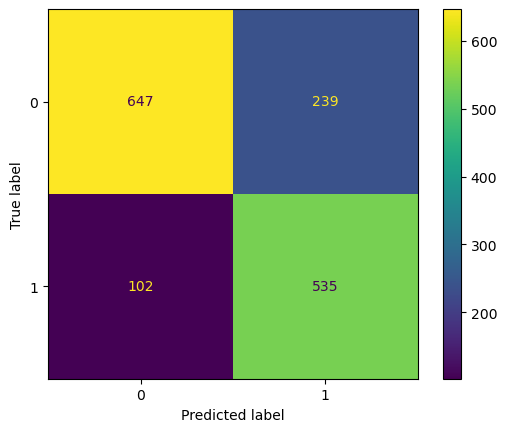

In [26]:
cm = confusion_matrix(labels, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
disp.plot(values_format = 'd')

plt.show()

### ii. Training model M only for T2 on D2 train

In [27]:
# train md2 model
epochs = 3

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    md2.train()
    total_loss = 0
    for batch in tqdm(train_loader_d2):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        optimizer2.zero_grad()

        output1, output2 = md2(**inputs)
        loss = loss_function2(output2, batch[2].view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer2.step()
        
    avg_loss = total_loss / len(train_loader_d2)
    print(f'\nAverage training loss: {avg_loss}')

Epoch 1/3


100%|██████████| 1374/1374 [02:59<00:00,  7.65it/s]



Average training loss: 0.9446030945410028
Epoch 2/3


100%|██████████| 1374/1374 [02:59<00:00,  7.65it/s]



Average training loss: 0.9143389739323912
Epoch 3/3


100%|██████████| 1374/1374 [02:59<00:00,  7.65it/s]


Average training loss: 0.9060182485517977


In [28]:
# Evaluate the model
md2.eval()
preds = []
labels = []
for batch in tqdm(val_loader_d2):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        output1, output2 = md2(**inputs)
        batch_preds = torch.argmax(output2, axis=1).detach().cpu().numpy().tolist()
        batch_labels = batch[2].detach().cpu().numpy().tolist()
        preds += batch_preds
        labels += batch_labels

# Calculate accuracy and print the result
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(labels, preds)
print(f'\nAccuracy Score for validation set: {acc}')

100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Accuracy Score for validation set: 0.5953420669577875


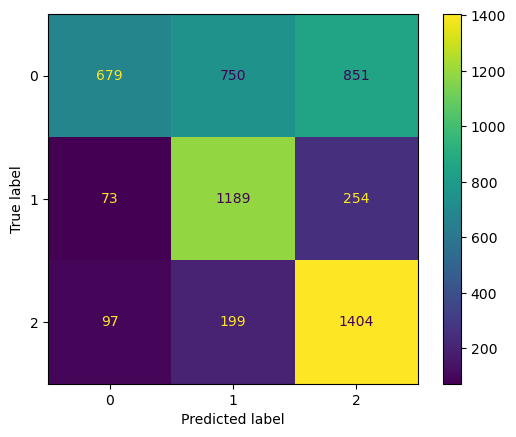

In [29]:
cm = confusion_matrix(labels, preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1, 2])
disp.plot(values_format = 'd')

plt.show()

### iii. Estimate the sentiment labels for the tweets in D1 and creating the augmented dataset

In [30]:
# get prediction on d1 train set
d1_train_augmented = d1_train.copy()
md2.eval()
preds = []
labels = []
for batch in tqdm(train_loader_d1):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        output1, output2 = md2(**inputs)
        batch_preds = torch.argmax(output2, axis=1).detach().cpu().numpy().tolist()
        preds += batch_preds
d1_train_augmented['predicted_sentiment_label'] = preds

# get predictions on d1 validation set
d1_val_augmented = d1_val.copy()
md2.eval()
preds = []
labels = []
for batch in tqdm(val_loader_d1):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        output1, output2 = md2(**inputs)
        batch_preds = torch.argmax(output2, axis=1).detach().cpu().numpy().tolist()
        preds += batch_preds
d1_val_augmented['predicted_sentiment_label'] = preds


100%|██████████| 96/96 [00:11<00:00,  8.09it/s]


In [31]:
d1_train_augmented.rename(columns={'target':'disaster_label'}).drop(columns=['input_ids']) \
.to_csv('./d1_train_augmented.csv', index=False)


In [32]:
d1_val_augmented.rename(columns={'target':'disaster_label'}).drop(columns=['input_ids']) \
.to_csv('./d1_val_augmented.csv', index=False)


In [33]:
# concatenate train and validation augmented datasets to form augmented dataset
d1_augmented = pd.concat([d1_train_augmented, d1_val_augmented], axis=0).rename(columns={'target':'disaster_label'}) \
.drop(columns=['input_ids'])
d1_augmented['disaster_label'] = d1_augmented['disaster_label'].astype(int)
d1_augmented.head()

,text,disaster_label,predicted_sentiment_label
6236,New #photo Oak in a snowstorm http://t.co/HK9Y...,1,0
5690,'You can only be rescued from where you actual...,0,0
3151,@runner_joy yes; especially new clients that w...,0,2
3753,Dear @CanonUSAimaging I brought it ;) #CanonBr...,0,0
703,**Let - Me - Be - Your - Hot - Blazing - Fanta...,0,1


In [34]:
# d1_augmented.to_csv("d1_augmented.csv", index=False)

In [35]:
# get attention masks and store in original datasets
d1_train['attention_masks'] = [i for i in d1_train_attention_masks]
d1_val['attention_masks'] = [i for i in d1_val_attention_masks]
d2_train['attention_masks'] = [i for i in d2_train_attention_masks]
d2_val['attention_masks'] = [i for i in d2_val_attention_masks]

In [36]:
d1_train.head(2)

,text,input_ids,target,attention_masks
6236,New #photo Oak in a snowstorm http://t.co/HK9Y...,"[[tensor(101), tensor(2047), tensor(1001), ten...",1.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."
5690,'You can only be rescued from where you actual...,"[[tensor(101), tensor(1005), tensor(2017), ten...",0.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."


### iv. Creating dataset D12

In [37]:
# concatenate both train datasets to create dataset for Multi-Task Learning
d12_train = pd.concat([d1_train.rename(columns={'target':'disaster_label'}), 
                       d2_train.rename(columns={'target':'predicted_sentiment_label'})], 
                      axis=0)

d12_train[['text', 'disaster_label', 'predicted_sentiment_label']].head()

,text,disaster_label,predicted_sentiment_label
6236,New #photo Oak in a snowstorm http://t.co/HK9Y...,1.0,NaN
5690,'You can only be rescued from where you actual...,0.0,NaN
3151,@runner_joy yes; especially new clients that w...,0.0,NaN
3753,Dear @CanonUSAimaging I brought it ;) #CanonBr...,0.0,NaN
703,**Let - Me - Be - Your - Hot - Blazing - Fanta...,0.0,NaN


In [38]:
d12_train[['text', 'disaster_label', 'predicted_sentiment_label']].tail()

,text,disaster_label,predicted_sentiment_label
6050,feelin lonely now after spendin the last 50 ho...,NaN,1.0
19128,I`m not comfortable with this announcement.,NaN,1.0
14791,"_x Haha, You sound like lizzie :L she`s got a ...",NaN,1.0
22042,Getting back my English minor exam soon. dum d...,NaN,2.0
21336,Every element in the DOM with children is a si...,NaN,0.0


In [39]:
# Create data loader for Multi-Task Learning
batch_size = 64

input_ids = torch.from_numpy(np.vstack(d12_train['input_ids'].values))
attention_masks = torch.from_numpy(np.vstack(d12_train['attention_masks'].values))
disaster_label = torch.from_numpy(np.vstack(d12_train['disaster_label'].values))
predicted_sentiment_label = torch.from_numpy(np.vstack(d12_train['predicted_sentiment_label'].values))

train_data_d12 = torch.utils.data.TensorDataset(input_ids,
                                                attention_masks,
                                                disaster_label,
                                                predicted_sentiment_label)

train_loader_d12 = torch.utils.data.DataLoader(train_data_d12, batch_size=batch_size, shuffle=True)

### v. We want to train M for both T1 and T2 on D12 by minimizing a weighted loss λ1 * l1 + λ2 * l2

In [40]:
# create helper function for training and evaluation for Multi-Task learning
def mtl_train(model, dataloader, max_epochs, lambda1, lambda2, print_loss=False):
    # define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # define loss function
    loss_function = nn.CrossEntropyLoss()
    # Train the model
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)

            input_ids, attention_masks, disaster_label, sentiment_label = batch

            disaster_label = disaster_label.flatten()
            disaster_mask = ~torch.isnan(disaster_label)
            disaster_indices = torch.arange(len(disaster_label)).to(device)[disaster_mask]

            sentiment_label = sentiment_label.flatten()
            sentiment_mask = ~torch.isnan(sentiment_label)
            sentiment_indices = torch.arange(len(sentiment_label)).to(device)[sentiment_mask]

            disaster_inputs = {'input_ids': input_ids[disaster_indices], 
                               'attention_mask': attention_masks[disaster_indices]}

            sentiment_inputs = {'input_ids': input_ids[sentiment_indices], 
                                'attention_mask': attention_masks[sentiment_indices]}

            disaster_label = disaster_label[disaster_indices].type(torch.LongTensor).to(device)
            sentiment_label = sentiment_label[sentiment_indices].type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            disaster_output, _ = model(**disaster_inputs)
            _, sentiment_output = model(**sentiment_inputs)

            loss1 = loss_function(disaster_output, disaster_label)
            loss2 = loss_function(sentiment_output, sentiment_label)

            loss = lambda1 * loss1 + lambda2 * loss2

            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        if print_loss:
            print(f'loss at epoch {epoch+1} = {total_loss/len(dataloader)}')
            
def mtl_evaluate(model, dataloader, return_t2_perf=False, return_labels=False):
    # get prediction on val set
    model.eval()
    disaster_preds = []
    disaster_labels = []
    sentiment_preds = []
    sentiment_labels = []
    for batch in tqdm(dataloader):
        batch = tuple(t.to(device) for t in batch)

        if return_t2_perf:
            input_ids, attention_masks, disaster_label, predicted_sentiment_label = batch
        else:
            input_ids, attention_masks, disaster_label, _ = batch
        with torch.no_grad():
            inputs = {'input_ids': input_ids, 'attention_mask': attention_masks}
            output1, output2 = model(**inputs)

            batch_disaster_preds = torch.argmax(output1, axis=1).detach().cpu().numpy().tolist()
            disaster_preds += batch_disaster_preds
            disaster_labels += disaster_label.cpu().numpy().flatten().tolist()
            
            if return_t2_perf:
                batch_sentiment_preds = torch.argmax(output2, axis=1).detach().cpu().numpy().tolist()
                sentiment_preds += batch_sentiment_preds
                sentiment_labels += predicted_sentiment_label.cpu().numpy().flatten().tolist()
    
    if return_t2_perf:
        print("Perf T1 - F1 score:", f1_score(disaster_labels, disaster_preds))
        print("Perf T2 - Accuracy score:", accuracy_score(sentiment_labels, sentiment_preds))
        if return_labels:
            return disaster_labels, disaster_preds, sentiment_labels, sentiment_preds
        else:
            return f1_score(disaster_labels, disaster_preds), accuracy_score(sentiment_labels, sentiment_preds)
    
    else:
        print("Perf T1 - F1 score:", f1_score(disaster_labels, disaster_preds))
        if return_labels:
            return disaster_labels, disaster_preds
        else:
            return f1_score(disaster_labels, disaster_preds)

In [41]:
# define new model to train on both disaster and sentiment labels
md12 = DisasterSentimentModel(num_labels1=2, num_labels2=3).to(device)
lambda1 = lambda2 = 0.5
mtl_train(md12, train_loader_d12, 3, lambda1, lambda2, True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 1 = 0.7450459146010848


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 2 = 0.7153781327951471


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]

loss at epoch 3 = 0.7087965304867825


In [42]:
# get attention masks for augmented dataset
d1_val_augmented['attention_masks'] = d1_val['attention_masks']

# create new dataloader for augmented val dataset
batch_size = 32

input_ids = torch.from_numpy(np.vstack(d1_val_augmented['input_ids'].values))
attention_masks = torch.from_numpy(np.vstack(d1_val_augmented['attention_masks'].values))
disaster_label = torch.from_numpy(np.vstack(d1_val_augmented['target'].values))
predicted_sentiment_label = torch.from_numpy(np.vstack(d1_val_augmented['predicted_sentiment_label'].values))

val_data_d1_augmented = torch.utils.data.TensorDataset(input_ids,
                                                attention_masks,
                                                disaster_label,
                                                predicted_sentiment_label)

val_loader_d1_augmented = torch.utils.data.DataLoader(val_data_d1_augmented, batch_size=batch_size, shuffle=False)

In [43]:
disaster_labels, disaster_preds, sentiment_labels, sentiment_preds = mtl_evaluate(md12, 
                                                                                  val_loader_d1_augmented, 
                                                                                  return_t2_perf=True, 
                                                                                  return_labels=True)


100%|██████████| 48/48 [00:11<00:00,  4.23it/s]

Perf T1 - F1 score: 0.709433962264151
Perf T2 - Accuracy score: 0.629021667760998


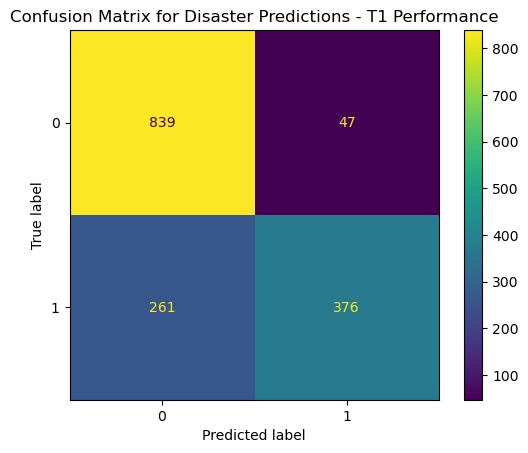

In [44]:
# get confusion matrix for disaster labels
cm = confusion_matrix(disaster_labels, disaster_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
disp.plot(values_format = 'd')
plt.title("Confusion Matrix for Disaster Predictions - T1 Performance")

plt.show()

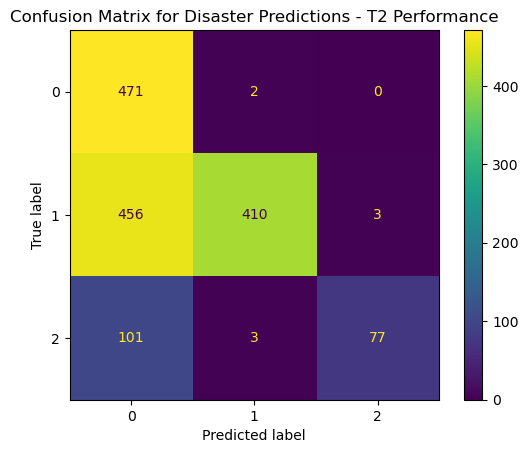

In [45]:
# get confusion matrix for sentiment labels
cm = confusion_matrix(sentiment_labels, sentiment_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1, 2])
disp.plot(values_format = 'd')
plt.title("Confusion Matrix for Disaster Predictions - T2 Performance")

plt.show()

### vi. Obtaining the best values of the hyper-parameters λ1,λ2

In [46]:
!pip install ax-platform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.4/387.4 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 28.2 MB/s eta 0:00:00


In [47]:
d1_val.head()

,text,input_ids,target,attention_masks
6912,Having trouble understanding the rotations wit...,"[[tensor(101), tensor(2383), tensor(4390), ten...",0.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2561,Wow Crackdown 3 uses multiple servers in multi...,"[[tensor(101), tensor(10166), tensor(8579), te...",0.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."
477,Heart disease prevention: What about secondhan...,"[[tensor(101), tensor(2540), tensor(4295), ten...",0.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4507,Cape Coral city leaders take part in mock hurr...,"[[tensor(101), tensor(4880), tensor(11034), te...",1.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4072,#np Avenged Sevenfold - Hail To The King,"[[tensor(101), tensor(1001), tensor(27937), te...",0.0,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [48]:
# update val data loader
val_data_d1_updated = torch.utils.data.TensorDataset(d1_val_tokens, 
                                             d1_val_attention_masks,
                                             torch.tensor(d1_val['target'].values).type(torch.LongTensor),
                                             torch.zeros(len(d1_val['target'].values)))
val_loader_d1_updated = torch.utils.data.DataLoader(val_data_d1_updated, batch_size=batch_size, shuffle=False)

### vi. Obtain the best values of the hyper-parameters lambda1 and lambda2

In [49]:
# define helper function to train and evaluate model
def train_evaluate(parameterization):
    md12_star = DisasterSentimentModel(num_labels1=2, num_labels2=3).to(device)
    lambda1 = parameterization["lambda1"]
    lambda2 = parameterization["lambda2"]
    mtl_train(md12_star, train_loader_d12, 2, lambda1, lambda2)
    f1_score_exp = mtl_evaluate(md12_star, val_loader_d1_updated, return_t2_perf=False, return_labels=False)
    return f1_score_exp

In [50]:
from ax import optimize

# optimizer is set to maximize f1 score
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lambda1", "type": 'range', "value_type": 'float', "bounds": [0.0, 1.0]},
        {"name": "lambda2", "type": 'range', "value_type": 'float', "bounds": [0.0, 1.0]},
    ],
    evaluation_function=train_evaluate,
    minimize = False,
    objective_name='f1_score',
    total_trials=7
)

[INFO 04-16 06:40:01] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lambda1', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='lambda2', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[]).
[INFO 04-16 06:40:01] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 04-16 06:40:01] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 04-16 06:40:01] ax.service.managed_loop: Started full optimization with 7 steps.
[INFO 04-16 06:40:01] ax.service.managed_loop: Running optimization trial 1...
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cl

Perf T1 - F1 score: 0.778588807785888


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48/48 [00:11<00:00,  4.22it/s]
[INFO 04-16 06:54:52] ax.service.managed_loop: Running optimization trial 3...


Perf T1 - F1 score: 0.7756360832690825


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48/48 [00:11<00:00,  4.22it/s]
[INFO 04-16 07:02:17] ax.service.managed_loop: Running optimization trial 4...


Perf T1 - F1 score: 0.7729970326409495


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48/48 [00:11<00:00,  4.23it/s]
[INFO 04-16 07:09:42] ax.service.managed_loop: Running optimization trial 5...


Perf T1 - F1 score: 0.7706270627062707


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48/48 [00:11<00:00,  4.22it/s]
[INFO 04-16 07:17:07] ax.service.managed_loop: Running optimization trial 6...


Perf T1 - F1 score: 0.7694915254237289


/opt/conda/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2115.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected i

Perf T1 - F1 score: 0.7839999999999999


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48/48 [00:11<00:00,  4.23it/s]
[WARNING 04-16 07:31:59] ax.modelbridge.cross_validation: Metric f1_score was unable to be reliably fit.
[W

Perf T1 - F1 score: 0.7671691792294807


In [51]:
print(best_parameters)

{'lambda1': 0.6342942588575995, 'lambda2': 0.9743182933953305}


After running the optimization algorithm above, we get the following values for lambda

$\lambda$1 = 0.6342942588575995

$\lambda$2 = 0.9743182933953305

### vii. Training model with the best lambdas

In [52]:
md12_star = DisasterSentimentModel(num_labels1=2, num_labels2=3).to(device)
lambda1 = best_parameters['lambda1']
lambda2 = best_parameters['lambda2']
mtl_train(md12_star, train_loader_d12, 8, lambda1, lambda2, True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 1 = 1.2660665298920286


100%|██████████| 439/439 [03:35<00:00,  2.03it/s]


loss at epoch 2 = 1.211152371078526


100%|██████████| 439/439 [03:35<00:00,  2.03it/s]


loss at epoch 3 = 1.2029695060095646


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 4 = 1.2004974724763076


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 5 = 1.1918705663811373


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 6 = 1.1871081619164938


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]


loss at epoch 7 = 1.1860810254863834


100%|██████████| 439/439 [03:36<00:00,  2.03it/s]

loss at epoch 8 = 1.1812104451086092


In [53]:
# create a data loader for d1 test data
test_tokens = torch.from_numpy(np.vstack(d1_test_preprocessed['input_ids']))
test_attention_masks = torch.where(test_tokens!=0, 1, 0)

# test data loader
batch_size = 16
test_data_d1 = torch.utils.data.TensorDataset(test_tokens,
                                              test_attention_masks)

test_loader_d1 = torch.utils.data.DataLoader(test_data_d1, batch_size=batch_size, shuffle=False)

In [54]:
# get prediction on d1 test set
md12_star.eval()
preds = []
labels = []
for batch in tqdm(test_loader_d1):
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        output1, output2 = md12_star(**inputs)
        batch_preds = torch.argmax(output1, axis=1).detach().cpu().numpy().tolist()
        preds += batch_preds
        
d1_test['target'] = preds

100%|██████████| 204/204 [00:25<00:00,  7.99it/s]


In [55]:
d1_test.head()

,id,keyword,location,text,flag,target
0,0,NaN,NaN,Just happened a terrible car crash,d1_test,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",d1_test,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",d1_test,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,d1_test,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,d1_test,1


In [56]:
# d1_test[['id', 'target']].to_csv("./team_whs_submission2_6.csv", index=False)

**This submission achieved an F1 score of 0.80 on the leaderboard.**

In [57]:
# saving all models
# torch.save(md1, "/content/MyDrive/MyDrive/bt5151_group_project/md1.bin")
# torch.save(md2, "/content/MyDrive/MyDrive/bt5151_group_project/md2.bin")
# torch.save(md12, "/content/MyDrive/MyDrive/bt5151_group_project/md12.bin")
# torch.save(md12_star, "/content/MyDrive/MyDrive/bt5151_group_project/md12_star.bin")

### viii. Hyper-parameter lambda2

**The best value for hyperparameter lambda2 is 0.97 which is greater than 0.**

**Lambda2 conveys the importance of the loss to be considered by the model. Let's suppose lambda2=0.6, the model needs to consider 60% or 0.6 times the loss to reduce the lost as best possible and improve the model performance.
In our case, lambda2 is 0.97 it means that we need to consider 0.97 times the loss from the sentiment task to improve the model in this task to predict whether a given text is indicative of a disaster or not. So we use the losses from both the models and multiply them with their specific coefficients to get the best possible f1 score.**

**This indicates the weight placed by the model on the loss from the sentiment task to improve the overall f1 score of the model after training on texts. Since this weight (lambda2) is more than lambda1, it means that the model penalizes the model less based on the loss obtained from the disaster task and more on the sentiment task. This makes sense because the primary task is disaster classification, as a result this should allow the model to reduce the sentiment loss further and improve the model based on the disaster classification score.**

**The externally sourced sentiment data improves the model accuracy because it pushes the model to use texts and labels from both disaster and sentiment datasets to classify the given text as best possible and using the lambda values allows the model to weight the individual losses and reduce the overall loss.**

### ix. Augmented Dataset used only for testing and not for training

**The augmented dataset is used only for testing and not for training the multi-task model because the predicted sentiment comes from another model trained on this dataset and the predictions also carry the error and the loss from that model. So if we train this model based on the output from the predicted sentiment, we would indirectly introduce the bias and loss from that model into the model that we intend to train and only increase the inaccurate predictions.**

# 5. Further Exploration

## Strategy 1

**In this strategy I use the model trained on both d1 and d2 (with optimal lambdas) and pass the embeddings from this model as features into a SVM model. I would also use the predicted sentiment on the text dataset as an additional feature, these combined features would allow the model to learn all the necessary characteristics of the data. The model would be evaluated based on its performance on d1 test data.**

**This strategy is expected to work because SVM can leverage kernel functions to better classify the data by understanding the features at a dimensional level. This might help the model generalize better.**

In [58]:
pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
for param in pretrained_bert.parameters():
    param.requires_grad = False
pretrained_bert = pretrained_bert.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
# Create data loader for training data and val data for D1
batch_size = 1
train_data_d1_strat1 = torch.utils.data.TensorDataset(d1_train_tokens,
                                               d1_train_attention_masks)
train_loader_d1_strat1 = torch.utils.data.DataLoader(train_data_d1_strat1, batch_size=batch_size, shuffle=False)

val_data_d1_strat1 = torch.utils.data.TensorDataset(d1_val_tokens, 
                                             d1_val_attention_masks)
val_loader_d1_strat1 = torch.utils.data.DataLoader(val_data_d1_strat1, batch_size=batch_size, shuffle=False)

# test data loader
test_data_d1_strat1 = torch.utils.data.TensorDataset(test_tokens,
                                              test_attention_masks)
test_loader_d1_strat1 = torch.utils.data.DataLoader(test_data_d1_strat1, batch_size=batch_size, shuffle=False)

In [60]:
def strat1_dataloader(dataloader, df):
    df_copy = df.copy()
    md12_star.eval()
    preds = []
    labels = []
    for batch in tqdm(dataloader):
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            output1, output2 = md12_star(**inputs)
            batch_preds = torch.argmax(output2, axis=1).detach().cpu().numpy().tolist()
            preds += batch_preds
    df_copy['predicted_sentiment_label'] = preds

    return_feature_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            last_hidden_states = pretrained_bert(input_ids=batch[0], attention_mask=batch[1])
            features = last_hidden_states[0][:,0,:].cpu().numpy()
            return_feature_list.append(features)

    return_features_strat1 = np.vstack(return_feature_list)

    return np.concatenate([return_features_strat1, df_copy['predicted_sentiment_label'].values.reshape(-1, 1)], axis=1)



In [61]:
train_strat1 = strat1_dataloader(train_loader_d1_strat1, d1_train)
val_strat1 = strat1_dataloader(val_loader_d1_strat1, d1_val)
test_strat1 = strat1_dataloader(test_loader_d1_strat1, d1_test)

100%|██████████| 3263/3263 [00:36<00:00, 88.81it/s]


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
svc_clf = SVC(random_state=2023).fit(train_strat1, d1_train['target'].values)
print("F1 score on validation data:", f1_score(d1_val['target'].values, svc_clf.predict(val_strat1)))

F1 score on validation data: 0.7939949958298581


In [63]:
import joblib
# joblib.dump(svc_clf, './svc_v1.pkl')

In [64]:
# get prediction on d1 test set
d1_test_strategy1 = d1_test.copy()
d1_test_strategy1['target'] = svc_clf.predict(test_strat1).astype(int)

In [65]:
# d1_test_strategy1[['id', 'target']].to_csv("./team_whs_strat1.csv", index=False)

## Strategy 2

**In this strategy, I have added my own preprocessing method where I clean the text and add a count vectorizer to tokenize the text,with this I would train 10 weakly trained classifiers that are trained on 10% of the training set each. Each model trains on 10% of the data that is exclusive to that model, this is to prevent data leakage. The idea here is that each model learns specific characteristics from the data and combined they add to the predictions of the voting classifier which gets the predictions based on a soft vote meaning it looks at the prediction probabilities from each model and makes a prediction.**

**This strategy is expected to work because it does not look at one model but several models trained on a subset of the training data and combines their predictions without necessarily overrelying on one model.**

In [66]:
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
def text_clean( raw_text ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_text).get_text() 
    # 2. Only keep letters
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    return ' '.join(words)

vectorizer = CountVectorizer()
X_train_strat2 = vectorizer.fit_transform(d1_train['text'].apply(text_clean))
X_val_strat2 = vectorizer.transform(d1_val['text'].apply(text_clean))
X_test_strat2 = vectorizer.transform(d1_test['text'].apply(text_clean))

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [68]:
from sklearn.ensemble import VotingClassifier

In [69]:
parts = 10
X_train_parts = np.array_split(X_train_strat2.A, parts)
y_train_parts = np.array_split(d1_train['target'].values, parts)

trained_models = []
for i in tqdm(range(parts)):
    lr_clf_model = LogisticRegression(max_iter=10000, random_state=2023).fit(X_train_parts[i], y_train_parts[i])
    trained_models.append((f'model{i}', lr_clf_model))

voting_clf = VotingClassifier(estimators = trained_models, voting='soft')
voting_clf.fit(X_train_strat2, d1_train['target'].values)
print("F1 score on validation data:", f1_score(d1_val['target'].values, voting_clf.predict(X_val_strat2)))

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


F1 score on validation data: 0.7658175842235004


In [70]:
import joblib
# joblib.dump(voting_clf, './voting_clf.pkl')

In [71]:
# get prediction on d1 test set
d1_test_strategy2 = d1_test.copy()
d1_test_strategy2['target'] = voting_clf.predict(X_test_strat2).astype(int)

In [72]:
# d1_test_strategy2[['id', 'target']].to_csv("./team_whs_strat2.csv", index=False)